In [ ]:
!pip install flask tensorflow pandas scikit-learn numpy matplotlib



In [ ]:
pip install requests pandas scikit-learn


In [ ]:
!pip install earthengine-api
!earthengine authenticate


Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W1111 09:37:17.405756 136602317881344 _default.py:683] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=tJ41vZwtaLSSncC-HYu_swA2fvrSH0kSd6VdTrlo6Gs&tc=GgxOn7ns_SkdnF_p4VQtHwVjO_Nmy6l2LywXDgpIB2w&cc=ixb5LNerGNmS9lUUYRU5TJCO_PoextB8JAiqt7PcXRk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeanS0aVFhf4QVHC4mWDLaeKZWo6

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
from flask import Flask, render_template, request



In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-samsoham55')
import ee

# Force authentication
ee.Authenticate(force=True)

# Initialize the Earth Engine library


print("Earth Engine initialized successfully!")



Earth Engine initialized successfully!


In [ ]:
import ee
from datetime import datetime

# Initialize the Earth Engine module
ee.Initialize()
#2013-03-18 to 2023-02-17
# Function to fetch Sentinel-1 data
def fetch_s1_data(location, start_date, end_date):
    point = ee.Geometry.Point(location)
    s1_image_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(point) \
        .filterDate(start_date, end_date)

    if s1_image_collection.size().getInfo() == 0:
        print("No Sentinel-1 images found for the specified date range.")
        return None

    s1_mean = s1_image_collection.mean()
    s1_value = s1_mean.select('VV').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('VV')

    return s1_value.getInfo() if s1_value is not None else None

# Function to fetch land cover data
def fetch_land_cover_data(location, start_date, end_date):
    point = ee.Geometry.Point(location)
    land_cover_image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(point) \
        .filterDate(start_date, end_date)

    if land_cover_image_collection.size().getInfo() == 0:
        print("No land cover images found for the specified date range.")
        return None

    land_cover_mean = land_cover_image_collection.mean()
    land_cover_value = land_cover_mean.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    )

    return land_cover_value.getInfo() or None

# Function to fetch NDVI data
def fetch_ndvi_data(location, start_date, end_date):
    point = ee.Geometry.Point(location)
    ndvi_image_collection = ee.ImageCollection('MODIS/MOD09GA_006_NDVI') \
        .filterBounds(point) \
        .filterDate(start_date, end_date)

    if ndvi_image_collection.size().getInfo() == 0:
        print("No NDVI images found for the specified date range.")
        return None

    ndvi_mean = ndvi_image_collection.mean()
    ndvi_value = ndvi_mean.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('NDVI')

    return ndvi_value.getInfo() if ndvi_value is not None else None

# Modify these variables to set the location and date range
location = [80.2785, 13.0878]  # Replace with your longitude and latitude
start_date = '2022-01-01'  # Modify the start date
end_date = '2022-01-21'  # Modify the end date

# Fetch data
s1_data = fetch_s1_data(location, start_date, end_date)
land_cover_data = fetch_land_cover_data(location, start_date, end_date)
ndvi_data = fetch_ndvi_data(location, start_date, end_date)

# Print results
print("Sentinel-1 Data:", s1_data)
print("Land Cover Data:", land_cover_data)
print("NDVI Data:", ndvi_data)


Sentinel-1 Data: 0.47185083841638303
Land Cover Data: {'QA_PIXEL': 22953, 'QA_RADSAT': 0, 'SR_B1': 9368, 'SR_B2': 10002.5, 'SR_B3': 11187, 'SR_B4': 11227.5, 'SR_B5': 15040.5, 'SR_B6': 14722, 'SR_B7': 12968, 'SR_QA_AEROSOL': 224, 'ST_ATRAN': 5489, 'ST_B10': 45290.5, 'ST_CDIST': 65, 'ST_DRAD': 1593.5, 'ST_EMIS': 9719.5, 'ST_EMSD': 81, 'ST_QA': 492.5, 'ST_TRAD': 9056, 'ST_URAD': 3609.5}
NDVI Data: 0.18720778822898865


In [ ]:
import ee
from datetime import datetime, timedelta

# Initialize the Earth Engine API
ee.Initialize()

# Function to fetch MODIS EVI Data for a range of dates
def fetch_evi_data(location, start_date, end_date):
    point = ee.Geometry.Point(location)

    # Define the MODIS EVI image collections
    image_collections = {
        "MOD13A1": "MODIS/061/MOD13A1",
        "MOD13A2": "MODIS/061/MOD13A2",
        "MOD13A3": "MODIS/061/MOD13A3",
        "MCD43A4": "MODIS/MCD43A4_006_EVI",
        "MOD09GA": "MODIS/MOD09GA_006_EVI"
    }

    # Convert the date strings to datetime objects
    start_date_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")

    # Loop through each date in the specified range
    current_date = start_date_dt
    while current_date <= end_date_dt:
        date_str = current_date.strftime("%Y-%m-%d")
        next_day_str = (current_date + timedelta(days=1)).strftime("%Y-%m-%d")
        print(f"\nFetching EVI data for {date_str}...")

        # Fetch and filter image collections
        for name, collection_id in image_collections.items():
            evi_image_collection = ee.ImageCollection(collection_id) \
                .filterBounds(point) \
                .filterDate(date_str, next_day_str) \
                .select('EVI')

            # Check if there are images available
            image_count = evi_image_collection.size().getInfo()
            if image_count > 0:
                # Get the individual images instead of reducing an empty collection
                evi_values = evi_image_collection.getInfo()['features']

                for feature in evi_values:
                    evi_image = ee.Image(feature['id'])
                    # Reduce the region to get the final EVI value for each image
                    evi_value = evi_image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=point,
                        scale=5000
                    ).get('EVI')

                    evi_value_info = evi_value.getInfo() if evi_value is not None else None
                    print(f"EVI Value from {name}: {evi_value_info}")  # Print the individual EVI value
            else:
                print(f"No EVI images found for {name} on {date_str}.")

        # Move to the next date
        current_date += timedelta(days=1)

# Example usage of fetch_evi_data
location = [-77.0369, 38.9072]  # Longitude, Latitude for Washington, D.C.
start_date = '2022-09-01'  # Start date
end_date = '2022-09-05'  # End date

fetch_evi_data(location, start_date, end_date)






Fetching EVI data for 2022-09-01...
No EVI images found for MOD13A1 on 2022-09-01.
No EVI images found for MOD13A2 on 2022-09-01.
EVI Value from MOD13A3: 2296
EVI Value from MCD43A4: 0.23686298213138907
EVI Value from MOD09GA: 0.24621623578825402

Fetching EVI data for 2022-09-02...
No EVI images found for MOD13A1 on 2022-09-02.
No EVI images found for MOD13A2 on 2022-09-02.
No EVI images found for MOD13A3 on 2022-09-02.
EVI Value from MCD43A4: 0.2179656538969617
EVI Value from MOD09GA: 0.18990036617559394

Fetching EVI data for 2022-09-03...
No EVI images found for MOD13A1 on 2022-09-03.
No EVI images found for MOD13A2 on 2022-09-03.
No EVI images found for MOD13A3 on 2022-09-03.
EVI Value from MCD43A4: 0.21771970240567998
EVI Value from MOD09GA: 0.21732476277930804

Fetching EVI data for 2022-09-04...
No EVI images found for MOD13A1 on 2022-09-04.
No EVI images found for MOD13A2 on 2022-09-04.
No EVI images found for MOD13A3 on 2022-09-04.
EVI Value from MCD43A4: 0.21747345350111477

In [ ]:
import ee
from datetime import datetime, timedelta

# Initialize the Earth Engine API
ee.Initialize()

# Function to fetch mean precipitation data from a given image collection
def fetch_mean_precipitation(collection_id, band_name, location, start_date, end_date, scale=5000):
    point = ee.Geometry.Point(location)
    data_collection = ee.ImageCollection(collection_id) \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .select(band_name)

    # Calculate mean precipitation over the date range
    mean_data = data_collection.mean()

    # Check if any images are returned
    image_count = data_collection.size().getInfo()
    if image_count == 0:
        print(f"No data available for {band_name} from {collection_id} for the period {start_date} to {end_date}.")
        return None

    mean_precipitation = mean_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=scale
    ).get(band_name)

    # Use the correct variable to get the mean precipitation value
    mean_precipitation_value = mean_precipitation.getInfo() if mean_precipitation else None
    if mean_precipitation_value is not None:
        print(f"Mean {band_name} from {collection_id} for {start_date} to {end_date}: {mean_precipitation_value} mm")
    else:
        print(f"Mean {band_name} from {collection_id} for {start_date} to {end_date}: No valid data returned.")
    return mean_precipitation_value

# Example usage of the function for multiple datasets
location = [13.0843, 80.2705]  # Example location (latitude, longitude)
start_date = '2021-12-01'
end_date = '2021-12-20'

# Fetch and print mean precipitation from CHIRPS dataset
chirps_mean_precipitation = fetch_mean_precipitation(
    "UCSB-CHG/CHIRPS/DAILY", 'precipitation', location, start_date, end_date
)

# Fetch and print mean precipitation from GPM IMERG dataset
gpm_mean_precipitation = fetch_mean_precipitation(
    "NASA/GPM_L3/IMERG_MONTHLY_V06", 'precipitation', location, start_date, end_date
)

# Fetch and print mean total precipitation from ERA5-Land dataset
era5_mean_precipitation = fetch_mean_precipitation(
    "ECMWF/ERA5_LAND/DAILY_AGGR", 'total_precipitation_sum', location, start_date, end_date
)


Mean precipitation from UCSB-CHG/CHIRPS/DAILY for 2021-12-01 to 2021-12-20: No valid data returned.
No data available for precipitation from NASA/GPM_L3/IMERG_MONTHLY_V06 for the period 2021-12-01 to 2021-12-20.
Mean total_precipitation_sum from ECMWF/ERA5_LAND/DAILY_AGGR for 2021-12-01 to 2021-12-20: No valid data returned.


In [ ]:
import ee
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initialize the Earth Engine library
ee.Initialize()

def fetch_historical_pollution_data(location, start_date, end_date):
    point = ee.Geometry.Point(location['longitude'], location['latitude'])
    no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    so2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2")
    co_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO")

    no2_data = no2_collection.filterDate(start_date, end_date).filterBounds(point)
    so2_data = so2_collection.filterDate(start_date, end_date).filterBounds(point)
    co_data = co_collection.filterDate(start_date, end_date).filterBounds(point)

    no2_images = no2_data.toList(no2_data.size())
    so2_images = so2_data.toList(so2_data.size())
    co_images = co_data.toList(co_data.size())

    pollution_data = []
    for i in range(no2_images.size().getInfo()):
        no2_image = ee.Image(no2_images.get(i))
        so2_image = ee.Image(so2_images.get(i))
        co_image = ee.Image(co_images.get(i))

        no2_value = no2_image.select('NO2_column_number_density').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=1000,
            bestEffort=True
        ).get('NO2_column_number_density').getInfo()

        so2_value = so2_image.select('SO2_column_number_density').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=1000,
            bestEffort=True
        ).get('SO2_column_number_density').getInfo()

        co_value = co_image.select('CO_column_number_density').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=1000,
            bestEffort=True
        ).get('CO_column_number_density').getInfo()

        pollution_data.append([no2_value, so2_value, co_value])

    return pd.DataFrame(pollution_data, columns=['NO2', 'SO2', 'CO'])

def train_random_forest_model(data):
    data = data.dropna()
    if data.empty or len(data) < 5:
        print("Not enough data to train the model.")
        return None

    X = data[['SO2', 'CO']]
    y = data['NO2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')
    return model

def classify_pollution(value, thresholds):
    if value < thresholds[0]:
        return 'Good'
    elif thresholds[0] <= value <= thresholds[1]:
        return 'Average'
    else:
        return 'Poor'

def predict_future_pollution(model, future_data):
    future_data_df = pd.DataFrame(future_data, columns=['SO2', 'CO'])
    future_pollution = model.predict(future_data_df)
    return future_pollution

# Example usage
location = {'latitude': 13.0827, 'longitude': 80.2707}  # Chennai coordinates
start_date = '2022-10-10'
end_date = '2022-10-20'

historical_data = fetch_historical_pollution_data(location, start_date, end_date)
rf_model = train_random_forest_model(historical_data)

if rf_model is not None:
    future_data = [[0.002, 0.003], [0.0025, 0.0028]]
    future_predictions = predict_future_pollution(rf_model, future_data)

    no2_thresholds = [0.001, 0.002]
    so2_thresholds = [0.001, 0.002]
    co_thresholds = [0.1, 0.2]

    classified_predictions = []
    for pred, (so2, co) in zip(future_predictions, future_data):
        no2_class = classify_pollution(pred, no2_thresholds)
        so2_class = classify_pollution(so2, so2_thresholds)
        co_class = classify_pollution(co, co_thresholds)
        classified_predictions.append({
            'NO2 Prediction': pred,
            'NO2 Classification': no2_class,
            'SO2 Prediction': so2,
            'SO2 Classification': so2_class,
            'CO Prediction': co,
            'CO Classification': co_class,
        })

    for prediction in classified_predictions:
        print(prediction)
else:
    print("Model training was unsuccessful due to insufficient data.")

Mean Squared Error: 2.02382030077679e-10
{'NO2 Prediction': 0.00010447584692699391, 'NO2 Classification': 'Good', 'SO2 Prediction': 0.002, 'SO2 Classification': 'Average', 'CO Prediction': 0.003, 'CO Classification': 'Good'}
{'NO2 Prediction': 0.00010447584692699391, 'NO2 Classification': 'Good', 'SO2 Prediction': 0.0025, 'SO2 Classification': 'Poor', 'CO Prediction': 0.0028, 'CO Classification': 'Good'}


In [ ]:
# Install required libraries
!pip install earthengine-api
!pip install folium

# Import libraries
import ee
import folium

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()


In [ ]:
# Install required libraries if not already installed
!pip install earthengine-api folium

In [ ]:

# Import libraries
import ee
import folium

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define locations with specified latitudes and longitudes
locations = [
    {"name": "Location 1", "lat": 23.0827, "lon": 80.2707},  # Chennai center
    {"name": "Location 2", "lat": 13.05, "lon": 80.25},
    {"name": "Location 3", "lat": 13.1, "lon": 80.3}
]

# Define dates for recent data
start_date = '2024-10-01'
end_date = '2024-10-31'

# Retrieve pollution data (SO2, CO) from Sentinel-5P for the specified period
so2_data = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2") \
    .filterDate(start_date, end_date) \
    .mean() \
    .select('SO2_column_number_density')

co_data = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_CO") \
    .filterDate(start_date, end_date) \
    .mean() \
    .select('CO_column_number_density')

# Define a map centered on the first location in the list
map_chennai = folium.Map(location=[locations[0]['lat'], locations[0]['lon']], zoom_start=10)

# Define visualization parameters for SO2 and CO
so2_vis_params = {
    'min': 0.0,
    'max': 0.0005,
    'palette': ['white', 'yellow', 'orange', 'red']
}

co_vis_params = {
    'min': 0.0,
    'max': 0.05,
    'palette': ['white', 'blue', 'purple', 'black']
}

# Add SO2 and CO pollution layers to the map
so2_layer = folium.raster_layers.ImageOverlay(
    image=so2_data.getMapId(so2_vis_params)['tile_fetcher'].url_format,
    bounds=[[13.0, 80.15], [13.2, 80.35]],  # Adjust these bounds as needed
    opacity=0.5,
    name='SO₂ Levels'
).add_to(map_chennai)

co_layer = folium.raster_layers.ImageOverlay(
    image=co_data.getMapId(co_vis_params)['tile_fetcher'].url_format,
    bounds=[[13.0, 80.15], [13.2, 80.35]],  # Adjust these bounds as needed
    opacity=0.5,
    name='CO Levels'
).add_to(map_chennai)

# Loop through each location to add markers with pollution levels
for loc in locations:
    # Create a point for the location
    point = ee.Geometry.Point([loc['lon'], loc['lat']])

    # Get SO2 and CO levels at this point
    so2_value = so2_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('SO2_column_number_density')

    co_value = co_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('CO_column_number_density')

    # Convert values to Python
    so2_value = so2_value.getInfo()
    co_value = co_value.getInfo()

    # Add a marker with pollution level data
    folium.Marker(
        location=[loc['lat'], loc['lon']],
        popup=f"{loc['name']}<br>SO₂: {so2_value:.5f} ppm<br>CO: {co_value:.5f} ppm",
        icon=folium.Icon(color='green')
    ).add_to(map_chennai)

# Add a legend for pollution levels
legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 150px;
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
     <strong>&nbsp; Pollution Levels</strong><br>
     &nbsp; <i style="background:white"></i>&nbsp; No Data<br>
     &nbsp; <i style="background:yellow"></i>&nbsp; Low (SO₂)<br>
     &nbsp; <i style="background:orange"></i>&nbsp; Moderate (SO₂)<br>
     &nbsp; <i style="background:red"></i>&nbsp; High (SO₂)<br>
     <br>
     &nbsp; <i style="background:white"></i>&nbsp; No Data<br>
     &nbsp; <i style="background:blue"></i>&nbsp; Low (CO)<br>
     &nbsp; <i style="background:purple"></i>&nbsp; Moderate (CO)<br>
     &nbsp; <i style="background:black"></i>&nbsp; High (CO)<br>
     </div>
     '''

map_chennai.get_root().html.add_child(folium.Element(legend_html))

# Add a layer control to switch between pollution types for each location
folium.LayerControl().add_to(map_chennai)

# Display the map
map_chennai


In [ ]:
!pip install geopandas matplotlib scikit-learn pandas



In [ ]:
!pip install pandas numpy scikit-learn geopandas matplotlib shapely



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib
from google.colab import drive

drive.mount('/content/drive')

# Step 1: Load the datasets
data_dir = '/content/drive/My Drive/ColabUploads/'  # Adjust this to your actual folder path

lst_data = pd.read_csv(data_dir + 'lst_4locations2021.csv')
lst_day_data = pd.read_csv(data_dir + 'lst_day_2000.csv')

# Step 2: Print column names to verify
print("LST Data Columns:", lst_data.columns.tolist())
print("LST Day Data Columns:", lst_day_data.columns.tolist())

# Step 3: Merge datasets based on 'converted_date'
lst_data['converted_date'] = pd.to_datetime(lst_data['converted_date'])
lst_day_data['converted_date'] = pd.to_datetime(lst_day_data['converted_date'])

merged_data = pd.merge(lst_data, lst_day_data, on='converted_date', how='outer', suffixes=('_lst', '_lst_day'))

# Step 4: Filter data to include only records from January 1, 2023 onwards
merged_data = merged_data[merged_data['converted_date'] >= '2023-01-01']

# Step 5: Check for missing values in important columns and handle them
print("Missing values in LST_AVE:", merged_data['LST_AVE'].isnull().sum())
print("Missing values in LST_Day_1km:", merged_data['LST_Day_1km'].isnull().sum())

# Option 1: Drop rows with missing LST_AVE and LST_Day_1km (preferred if few missing)
merged_data = merged_data.dropna(subset=['LST_AVE', 'LST_Day_1km'])

# Option 2: Alternatively, fill missing values with the mean of the respective columns
# merged_data['LST_AVE'] = merged_data['LST_AVE'].fillna(merged_data['LST_AVE'].mean())
# merged_data['LST_Day_1km'] = merged_data['LST_Day_1km'].fillna(merged_data['LST_Day_1km'].mean())

# Step 6: Split the data into training and testing sets
train_data = merged_data[merged_data['converted_date'] < '2024-01-01']
test_data = merged_data[merged_data['converted_date'] >= '2024-01-01']

# Step 7: Prepare features and target for training
X_train = train_data[['LST_AVE', 'LST_Day_1km']]  # Features
y_train = train_data['LST_AVE']  # Target (LST_AVE)

X_test = test_data[['LST_AVE', 'LST_Day_1km']]  # Features for testing
y_test = test_data['LST_AVE']  # Target for testing

# Step 8: Train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 9: Evaluate the model using Mean Absolute Error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Data: {mae}")

# Step 10: Save the model for future predictions
joblib.dump(model, data_dir + 'temperature_model.pkl')
print("Model saved successfully.")

# Step 11: Set the future date for prediction
future_date = "2024-11-25"  # Change this date to make predictions for a different future date

future_data = pd.DataFrame({
    'LST_AVE': [None],  # Actual LST_AVE value for the future date (if available)
    'LST_Day_1km': [None]  # Actual LST_Day_1km value for the future date (if available)
})

future_prediction = model.predict(future_data)

# Step 14: Calculate the final value using the formula final_value = (prediction * 0.02) - 273
final_value = (future_prediction[0] * 0.02) - 273

# Print the final temperature prediction
print(f"Temperature Prediction for {future_date}: {final_value}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LST Data Columns: ['converted_date', '.geo', 'LST_AVE']
LST Day Data Columns: ['system:index', 'LST_Day_1km', '.geo', 'converted_date']
Missing values in LST_AVE: 56208
Missing values in LST_Day_1km: 151
Mean Absolute Error on Test Data: 2.3730653377629976
Model saved successfully.
Temperature Prediction for 2024-11-25: 47.50040000000001


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib
from google.colab import drive

drive.mount('/content/drive')
# Load the datasets
data_dir = '/content/drive/My Drive/ColabUploads/'  # Adjust this to your actual folder path

lst_data = pd.read_csv(data_dir + 'lst_4locations2021.csv')
lst_day_data = pd.read_csv(data_dir + 'lst_day_2000.csv')

# Merge datasets based on 'converted_date'
lst_data['converted_date'] = pd.to_datetime(lst_data['converted_date'])
lst_day_data['converted_date'] = pd.to_datetime(lst_day_data['converted_date'])

merged_data = pd.merge(lst_data, lst_day_data, on='converted_date', how='outer', suffixes=('_lst', '_lst_day'))

def predict_temperature(input_date):
    input_date = pd.to_datetime(input_date)

    # Check if the input date exists in the merged dataset
    if input_date not in merged_data['converted_date'].values:
        print(f"Date {input_date.date()} not found in the dataset.")
        return

    # Filter data for training (from 2023-01-01 to day before input date)
    train_data = merged_data[(merged_data['converted_date'] >= '2023-01-01') &
                             (merged_data['converted_date'] < input_date)]

    # If there's no data for training, notify the user
    if train_data.empty:
        print("Not enough data to train the model.")
        return

    # Check for missing values in the training data
    train_data = train_data.dropna(subset=['LST_AVE', 'LST_Day_1km'])  # Drop rows with NaN values

    # Prepare features and target for training
    X_train = train_data[['LST_AVE', 'LST_Day_1km']]  # Features
    y_train = train_data['LST_AVE']  # Target (LST_AVE)

    # If y_train is empty after dropping NaNs, notify the user
    if y_train.isnull().sum() > 0 or y_train.empty:
        print("No valid training data available.")
        return

    # Train the Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prepare the data for prediction (the input date)
    prediction_data = merged_data[merged_data['converted_date'] == input_date][['LST_AVE', 'LST_Day_1km']]

    # Check if prediction data is available
    if prediction_data.empty:
        print(f"No data available for prediction on {input_date.date()}.")
        return

    # Make a prediction for the specified date
    future_prediction = model.predict(prediction_data)
    actual_value = prediction_data['LST_AVE'].values[0]  # Get the actual value

    # Calculate accuracy
    accuracy = 100 - (abs(actual_value - future_prediction[0]) / actual_value * 100)

    # Print results
    print(f"Predicted Temperature for {input_date.date()}: {future_prediction[0]:.2f}")
    print(f"Actual Temperature for {input_date.date()}: {actual_value:.2f}")
    print(f"Accuracy: {accuracy:.2f}%")

# Example usage
input_date = "2023-03-20"  # Change this to the desired date
predict_temperature(input_date)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Predicted Temperature for 2023-03-20: 14913.95
Actual Temperature for 2023-03-20: 14962.00
Accuracy: 99.68%


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Merged Data Columns: ['system:index', 'hourlyPrecipRate', 'hourlyPrecipRateGC', 'observationTimeFlag', '.geo', 'converted_date', 'system:index_spei', 'SPEI_01_month', '.geo_spei', 'system:index_chirps', 'precipitation', '.geo_chirps']
Heavy Rain Prediction Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    140902
           1       1.00      1.00      1.00      9576

    accuracy                           1.00    150478
   macro avg       1.00      1.00      1.00    150478
weighted avg       1.00      1.00      1.00    150478

Heavy Rain Confusion Matrix:
[[140902      0]
 [     0   9576]]
Drought Prediction Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150478

    accuracy                           1.00    150478
   macro avg       1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Models saved successfully.


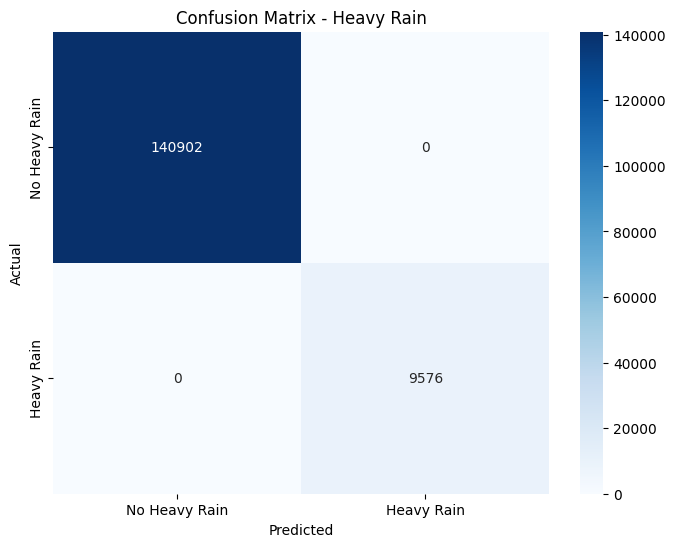

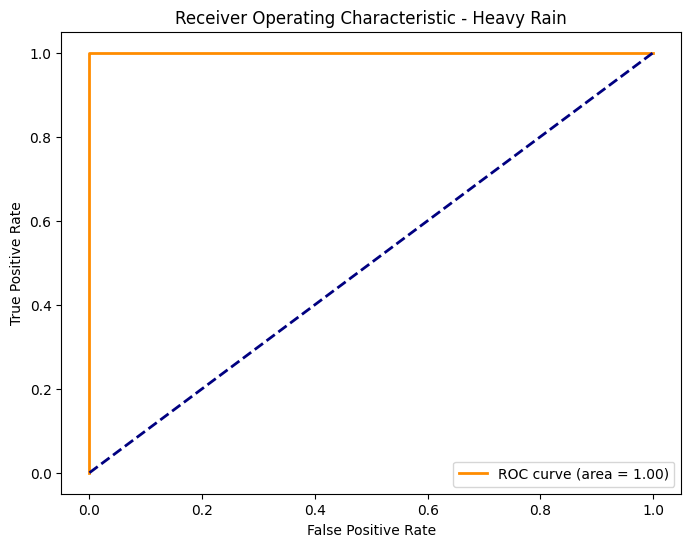

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


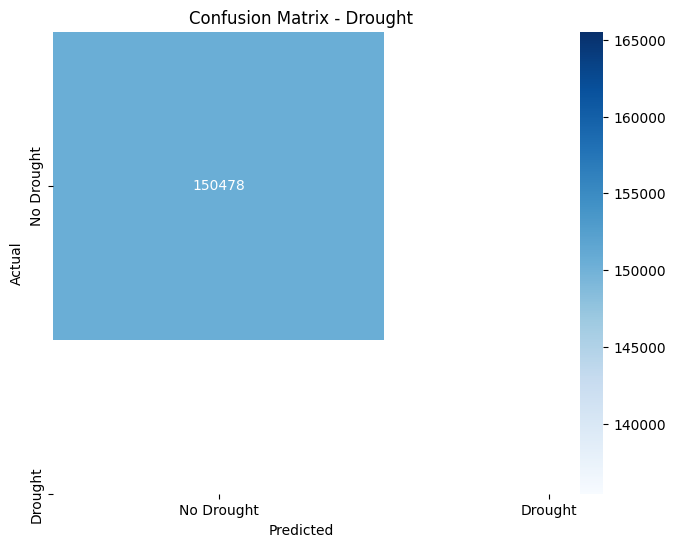

Drought model only predicted one class, so ROC curve cannot be plotted.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from google.colab import drive

# Step 1: Mount Google Drive in Colab
drive.mount('/content/drive')

# Step 2: Set the path to the directory in Google Drive where your data files are stored
data_dir = '/content/drive/My Drive/ColabUploads/filtered_data/'  # Adjust this to your actual folder path

# Step 3: Load the datasets
precipitation_hourly_data = pd.read_csv(data_dir + 'precipitation_hourly_2018_onward.csv')
spei_data = pd.read_csv(data_dir + 'spei_filtered_data.csv')
chirps_data_filtered = pd.read_csv(data_dir + 'chirps_data_filtered.csv')

# Step 4: Convert 'converted_date' to datetime format for all datasets
precipitation_hourly_data['converted_date'] = pd.to_datetime(precipitation_hourly_data['converted_date'])
spei_data['converted_date'] = pd.to_datetime(spei_data['converted_date'])
chirps_data_filtered['converted_date'] = pd.to_datetime(chirps_data_filtered['converted_date'])

# Step 5: Filter the precipitation data to only include records from 2018-01-01 onward
precipitation_hourly_data = precipitation_hourly_data[precipitation_hourly_data['converted_date'] >= '2018-01-01']

# Step 6: Merge datasets based on 'converted_date'
merged_data = precipitation_hourly_data.merge(spei_data, on='converted_date', how='outer', suffixes=('', '_spei'))
merged_data = merged_data.merge(chirps_data_filtered, on='converted_date', how='outer', suffixes=('', '_chirps'))

# Step 7: Filter data to only include records from 2014 onwards
merged_data = merged_data[merged_data['converted_date'] >= '2014-01-01']

# Step 8: Print merged data columns to ensure proper merging
print("Merged Data Columns:", merged_data.columns.tolist())

# Step 9: Create target columns for heavy rain and drought
merged_data['heavy_rain'] = (merged_data['precipitation'] > 10).astype(int)  # Example threshold for heavy rain
merged_data['drought'] = (merged_data['SPEI_01_month'] < 0).astype(int)  # Example threshold for drought

# Step 10: Drop non-numeric columns (e.g., geo-related columns)
non_numeric_columns = ['.geo', '.geo_spei', '.geo_chirps', 'system:index', 'system:index_spei', 'system:index_chirps']
merged_data = merged_data.drop(columns=non_numeric_columns)

# Step 11: Split the data into training and testing sets (using data before 2024 for training)
train_data = merged_data[merged_data['converted_date'] < '2024-01-01']
test_data = merged_data[merged_data['converted_date'] >= '2024-01-01']

# Features and target for training
target_heavy_rain = 'heavy_rain'
target_drought = 'drought'

X_train = train_data.drop(columns=[target_heavy_rain, target_drought, 'converted_date'])  # Drop target and date columns
y_train_heavy_rain = train_data[target_heavy_rain]  # Target variable for heavy rain
y_train_drought = train_data[target_drought]  # Target variable for drought

# Features and target for testing
X_test = test_data.drop(columns=[target_heavy_rain, target_drought, 'converted_date'])  # Drop target and date columns
y_test_heavy_rain = test_data[target_heavy_rain]  # Target variable for heavy rain
y_test_drought = test_data[target_drought]  # Target variable for drought

# Step 12: Train Random Forest Classifier models for predicting heavy rain and drought
rain_model = RandomForestClassifier(n_estimators=100, random_state=42)
rain_model.fit(X_train, y_train_heavy_rain)

drought_model = RandomForestClassifier(n_estimators=100, random_state=42)
drought_model.fit(X_train, y_train_drought)

# Step 13: Make predictions on the test set
rain_predictions = rain_model.predict(X_test)
drought_predictions = drought_model.predict(X_test)

# Step 14: Evaluate the models using classification report and confusion matrix
print("Heavy Rain Prediction Report:")
print(classification_report(y_test_heavy_rain, rain_predictions))
print("Heavy Rain Confusion Matrix:")
print(confusion_matrix(y_test_heavy_rain, rain_predictions))

print("Drought Prediction Report:")
print(classification_report(y_test_drought, drought_predictions))
print("Drought Confusion Matrix:")
print(confusion_matrix(y_test_drought, drought_predictions))

# Step 15: Save the models for later use
joblib.dump(rain_model, data_dir + 'rain_model.pkl')
joblib.dump(drought_model, data_dir + 'drought_model.pkl')

print("Models saved successfully.")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


conf_matrix_rain = confusion_matrix(y_test_heavy_rain, rain_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_rain, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heavy Rain', 'Heavy Rain'], yticklabels=['No Heavy Rain', 'Heavy Rain'])
plt.title('Confusion Matrix - Heavy Rain')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plotting ROC Curve for Heavy Rain
fpr_rain, tpr_rain, _ = roc_curve(y_test_heavy_rain, rain_model.predict_proba(X_test)[:, 1])
roc_auc_rain = auc(fpr_rain, tpr_rain)

plt.figure(figsize=(8,6))
plt.plot(fpr_rain, tpr_rain, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rain)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Heavy Rain')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrix for Drought
conf_matrix_drought = confusion_matrix(y_test_drought, drought_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_drought, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drought', 'Drought'], yticklabels=['No Drought', 'Drought'])
plt.title('Confusion Matrix - Drought')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plotting ROC Curve for Drought (if class 1 exists in predictions)
# Only plot if there are any predicted values for Drought (class 1)
if len(set(drought_predictions)) > 1:
    fpr_drought, tpr_drought, _ = roc_curve(y_test_drought, drought_model.predict_proba(X_test)[:, 1])
    roc_auc_drought = auc(fpr_drought, tpr_drought)

    plt.figure(figsize=(8,6))
    plt.plot(fpr_drought, tpr_drought, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_drought)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Drought')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Drought model only predicted one class, so ROC curve cannot be plotted.")


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Create new precipitation categories
def categorize_precipitation(row):
    if row['hourlyPrecipRate'] > 50 or row['precipitation'] > 100:
        return 'Heavy Rain'
    elif row['hourlyPrecipRate'] > 30 or (row['precipitation'] > 20 and row['precipitation'] <= 100):
        return 'Moderate Rain'
    elif row['hourlyPrecipRate'] > 0 or row['precipitation'] > 0:
        return 'Light Rain'
    else:
        return 'No Rain'

# Apply this categorization to both 'hourlyPrecipRate' and 'precipitation'
merged_data['precip_category'] = merged_data.apply(categorize_precipitation, axis=1)

# Step 2: Handle missing data or 0 mm values
merged_data = merged_data.dropna(subset=['hourlyPrecipRate', 'precipitation'])

# Step 3: Extract features and target labels
features = merged_data.drop(columns=['precip_category', 'converted_date'])
target = merged_data['precip_category']

# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier with class weighting
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

# Step 7: Print the classification report
print(classification_report(y_test, y_pred))

# You can also print out the precision, recall, and F1-score for each category (No Rain, Light Rain, Moderate Rain, Heavy Rain)

# Example prediction for a new date
def predict_precipitation(date_str):
    # Get data for the specific date (as shown in the previous code)
    date = pd.to_datetime(date_str)
    test_data = merged_data[merged_data['converted_date'] == date]

    # Prepare feature data (same as above)
    test_features = test_data.drop(columns=['precip_category', 'converted_date'])

    # Predict
    predicted_category = model.predict(test_features)

    return predicted_category[0]

# Example usage for a specific date
date_input = '2023-08-12'  # Replace with the date you want to predict
result = predict_precipitation(date_input)
print(f"Prediction for {date_input}: {result}")


KeyError: 'hourlyPrecipRate'

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Check if 'hourlyPrecipRate' and 'precipitation' columns are in the DataFrame
expected_columns = ['hourlyPrecipRate', 'precipitation']
for col in expected_columns:
    if col not in merged_data.columns:
        raise KeyError(f"Column '{col}' not found in merged_data. Please ensure it exists or rename it accordingly.")

# Step 1: Create new precipitation categories
def categorize_precipitation(row):
    if row['hourlyPrecipRate'] > 50 or row['precipitation'] > 100:
        return 'Heavy Rain'
    elif row['hourlyPrecipRate'] > 30 or (row['precipitation'] > 20 and row['precipitation'] <= 100):
        return 'Moderate Rain'
    elif row['hourlyPrecipRate'] > 0 or row['precipitation'] > 0:
        return 'Light Rain'
    else:
        return 'No Rain'

# Apply this categorization to both 'hourlyPrecipRate' and 'precipitation'
merged_data['precip_category'] = merged_data.apply(categorize_precipitation, axis=1)

# Step 2: Handle missing data or 0 mm values
# Drop rows with missing 'hourlyPrecipRate' or 'precipitation' values
merged_data = merged_data.dropna(subset=['hourlyPrecipRate', 'precipitation'])

# Step 3: Extract features and target labels
features = merged_data.drop(columns=['precip_category', 'converted_date'])
target = merged_data['precip_category']

# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier with class weighting
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

# Step 7: Print the classification report
print(classification_report(y_test, y_pred))

# Example prediction for a new date
def predict_precipitation(date_str):
    # Convert the date string to datetime format
    date = pd.to_datetime(date_str)

    # Filter the DataFrame for the specific date
    test_data = merged_data[merged_data['converted_date'] == date]

    if test_data.empty:
        print(f"No data available for date {date_str}")
        return None

    # Prepare feature data by removing the target and date columns
    test_features = test_data.drop(columns=['precip_category', 'converted_date'])

    # Predict the precipitation category
    predicted_category = model.predict(test_features)

    return predicted_category[0]

# Example usage for a specific date
date_input = '2024-03-25'  # Replace with the date you want to predict
result = predict_precipitation(date_input)
if result:
    print(f"Prediction for {date_input}: {result}")


KeyError: "Column 'hourlyPrecipRate' not found in merged_data. Please ensure it exists or rename it accordingly."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Absolute Error (MAE): 0.020525677483282552
Root Mean Squared Error (RMSE): 0.03672909111383586


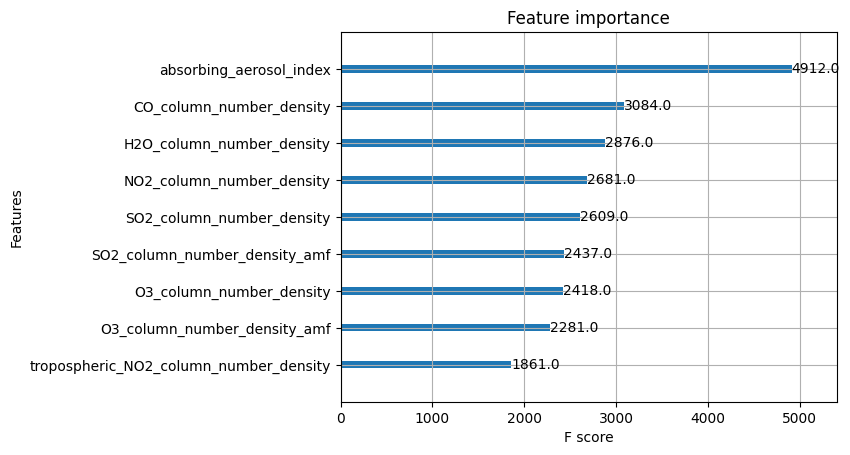

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import drive

# Step 1: Mount Google Drive in Colab
drive.mount('/content/drive')


# Google Drive path to load the datasets
data_dir = '/content/drive/My Drive/ColabUploads'

# Load each dataset
aer_data = pd.read_csv(f'{data_dir}/Sentinel5P_AER_AI_Chennai_Export.csv')
co_data = pd.read_csv(f'{data_dir}/Sentinel5P_CO_Chennai_Export.csv')
o3_data = pd.read_csv(f'{data_dir}/Sentinel5P_O3_Chennai_Export.csv')
so2_data = pd.read_csv(f'{data_dir}/Sentinel5P_SO2_Chennai_Export.csv')
no2_data = pd.read_csv(f'{data_dir}/Sentinel5P_NO2_Chennai_Export.csv')

# Merge datasets on 'date' column
merged_data = aer_data.merge(co_data, on='date', how='inner')
merged_data = merged_data.merge(o3_data, on='date', how='inner')
merged_data = merged_data.merge(so2_data, on='date', how='inner')
merged_data = merged_data.merge(no2_data, on='date', how='inner')

# Drop rows with missing values
merged_data.dropna(inplace=True)

# Define an "overall pollution level" as a composite metric
# Here we take the mean of each pollutant’s normalized level as an example
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data.drop(columns=['date']))

# Calculate pollution level (mean of scaled values across pollutants)
merged_data['pollution_level'] = merged_data_scaled.mean(axis=1)

# Features (X) and target (y)
X = merged_data.drop(columns=['date', 'pollution_level'])
y = merged_data['pollution_level']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Feature Importance
xgb.plot_importance(model)
plt.show()


In [ ]:
import numpy as np

# Assuming `X_future` is a DataFrame containing future feature values
# Here we create future data by taking historical mean values as a simple approach
X_future = X.mean(axis=0).to_frame().T  # Take mean of each feature as future values

# Make a prediction for the future pollution level
future_pollution_level = model.predict(X_future)[0]
print(f"Predicted Pollution Level: {future_pollution_level}")

# Define thresholds based on training data percentiles
good_threshold = y.quantile(0.33)
average_threshold = y.quantile(0.66)

# Classify the predicted pollution level
if future_pollution_level <= good_threshold:
    pollution_status = "Good"
elif future_pollution_level <= average_threshold:
    pollution_status = "Average"
else:
    pollution_status = "Worst"

print(f"Pollution Level Classification: {pollution_status}")


Predicted Pollution Level: 0.058096881955862045
Pollution Level Classification: Average


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Absolute Error (MAE) for the test date: 0.05085534207781837
Root Mean Squared Error (RMSE) for the test date: 0.06111291123269987
Prediction Accuracy for the test date: 0.00%


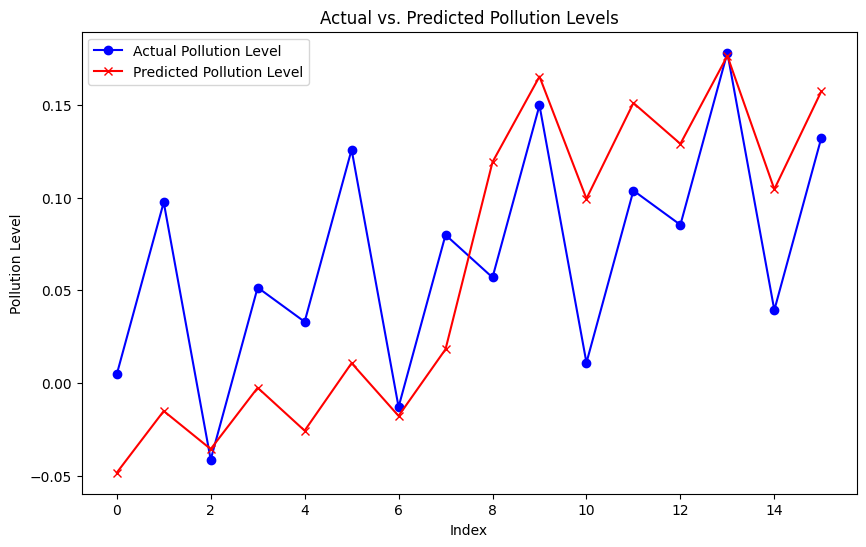

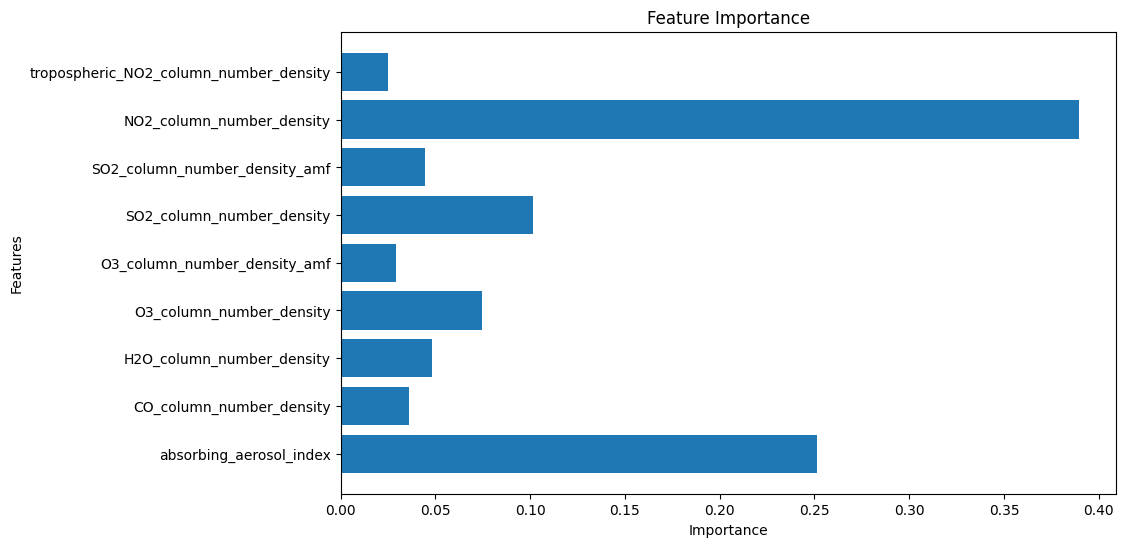

Predicted pollution levels saved as 'predicted_pollution_levels.csv' in Google Drive.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive

# Step 1: Mount Google Drive in Colab
drive.mount('/content/drive')

# Google Drive path to load the datasets
data_dir = '/content/drive/My Drive/ColabUploads'

# Load each dataset
aer_data = pd.read_csv(f'{data_dir}/Sentinel5P_AER_AI_Chennai_Export.csv')
co_data = pd.read_csv(f'{data_dir}/Sentinel5P_CO_Chennai_Export.csv')
o3_data = pd.read_csv(f'{data_dir}/Sentinel5P_O3_Chennai_Export.csv')
so2_data = pd.read_csv(f'{data_dir}/Sentinel5P_SO2_Chennai_Export.csv')
no2_data = pd.read_csv(f'{data_dir}/Sentinel5P_NO2_Chennai_Export.csv')

# Merge datasets on 'date' column
merged_data = aer_data.merge(co_data, on='date', how='inner')
merged_data = merged_data.merge(o3_data, on='date', how='inner')
merged_data = merged_data.merge(so2_data, on='date', how='inner')
merged_data = merged_data.merge(no2_data, on='date', how='inner')

# Drop rows with missing values
merged_data.dropna(inplace=True)

# Normalize pollutant data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data.drop(columns=['date']))

# Calculate an "overall pollution level"
merged_data['pollution_level'] = merged_data_scaled.mean(axis=1)

# Define features and target
X = merged_data.drop(columns=['date', 'pollution_level'])
y = merged_data['pollution_level']

# Convert the 'date' column to datetime format if it's not already
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Custom test date - specify any date in the dataset
test_date = pd.to_datetime("2024-03-26")  # Replace "YYYY-MM-DD" with the date you want to test

# Check if the test date exists in the dataset
if test_date not in merged_data['date'].values:
    raise ValueError(f"The specified test date {test_date} does not exist in the dataset.")

# Split data based on custom test date
train_data = merged_data[merged_data['date'] < test_date]
test_data = merged_data[merged_data['date'] == test_date]

# Check if test_data has any rows
if test_data.empty:
    raise ValueError(f"No data available for the specified test date: {test_date}. Please choose another date.")

# Define training and test sets
X_train = train_data.drop(columns=['date', 'pollution_level'])
y_train = train_data['pollution_level']
X_test = test_data.drop(columns=['date', 'pollution_level'])
y_test = test_data['pollution_level']

# Train Random Forest model
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Predict pollution level for the test date
y_pred = model.predict(X_test)

# Evaluate model with MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error (MAE) for the test date: {mae}")
print(f"Root Mean Squared Error (RMSE) for the test date: {rmse}")

# Handle MAPE carefully to avoid errors from small values
epsilon = 1e-10  # Small constant to avoid division by zero
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100  # Adding epsilon to the denominator

# Calculate accuracy percentage
accuracy = 100 - mape

# Check for any negative accuracy due to outliers or issues
if accuracy < 0:
    accuracy = 0

print(f"Prediction Accuracy for the test date: {accuracy:.2f}%")

# Plot Actual vs. Predicted values for better visual inspection
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Pollution Level', color='blue', marker='o')
plt.plot(y_pred, label='Predicted Pollution Level', color='red', marker='x')
plt.legend()
plt.title('Actual vs. Predicted Pollution Levels')
plt.xlabel('Index')
plt.ylabel('Pollution Level')
plt.show()

# Display feature importance
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Create a DataFrame to store actual and predicted pollution levels
predicted_data = pd.DataFrame({
    'date': test_data['date'],
    'actual_pollution_level': y_test,
    'predicted_pollution_level': y_pred
})

# Save the DataFrame to a CSV file
predicted_data.to_csv('/content/drive/My Drive/ColabUploads/predicted_pollution_levels.csv', index=False)

print("Predicted pollution levels saved as 'predicted_pollution_levels.csv' in Google Drive.")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive

# Step 1: Mount Google Drive in Colab
drive.mount('/content/drive')

# Google Drive path to load the datasets
data_dir = '/content/drive/My Drive/ColabUploads'

# Load each dataset
aer_data = pd.read_csv(f'{data_dir}/Sentinel5P_AER_AI_Chennai_Export.csv')
co_data = pd.read_csv(f'{data_dir}/Sentinel5P_CO_Chennai_Export.csv')
o3_data = pd.read_csv(f'{data_dir}/Sentinel5P_O3_Chennai_Export.csv')
so2_data = pd.read_csv(f'{data_dir}/Sentinel5P_SO2_Chennai_Export.csv')
no2_data = pd.read_csv(f'{data_dir}/Sentinel5P_NO2_Chennai_Export.csv')

# Merge datasets on 'date' column
merged_data = aer_data.merge(co_data, on='date', how='inner')
merged_data = merged_data.merge(o3_data, on='date', how='inner')
merged_data = merged_data.merge(so2_data, on='date', how='inner')
merged_data = merged_data.merge(no2_data, on='date', how='inner')

# Drop rows with missing values
merged_data.dropna(inplace=True)

# Normalize pollutant data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data.drop(columns=['date']))

# Calculate an "overall pollution level"
merged_data['pollution_level'] = merged_data_scaled.mean(axis=1)

# Define features and target
X = merged_data.drop(columns=['date', 'pollution_level'])
y = merged_data['pollution_level']

# Convert the 'date' column to datetime format if it's not already
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Filter data for the year 2024
merged_data_2024 = merged_data[merged_data['date'].dt.year == 2024]

# Define features and target for 2024 data
X_2024 = merged_data_2024.drop(columns=['date', 'pollution_level'])
y_2024 = merged_data_2024['pollution_level']

# Train Random Forest model using the entire data
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)

# Predict pollution levels for all 2024 dates
y_pred_2024 = model.predict(X_2024)

# Evaluate model with MAE and RMSE
mae_2024 = mean_absolute_error(y_2024, y_pred_2024)
rmse_2024 = np.sqrt(mean_squared_error(y_2024, y_pred_2024))
print(f"Mean Absolute Error (MAE) for 2024: {mae_2024}")
print(f"Root Mean Squared Error (RMSE) for 2024: {rmse_2024}")

# Handle MAPE carefully to avoid errors from small values
epsilon = 1e-10  # Small constant to avoid division by zero
mape_2024 = np.mean(np.abs((y_2024 - y_pred_2024) / (y_2024 + epsilon))) * 100  # Adding epsilon to the denominator

# Calculate accuracy percentage
accuracy_2024 = 100 - mape_2024

# Check for any negative accuracy due to outliers or issues
if accuracy_2024 < 0:
    accuracy_2024 = 0

print(f"Prediction Accuracy for 2024: {accuracy_2024:.2f}%")

# Save actual and predicted pollution levels for all dates in 2024 to a CSV file
predicted_data_2024 = pd.DataFrame({
    'date': merged_data_2024['date'],
    'actual_pollution_level': y_2024,
    'predicted_pollution_level': y_pred_2024
})

# Save the DataFrame to a CSV file in Google Drive
predicted_data_2024.to_csv('/content/drive/My Drive/ColabUploads/predicted_pollution_levels_2024.csv', index=False)

print("Predicted pollution levels for all 2024 dates saved as 'predicted_pollution_levels_2024.csv' in Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Absolute Error (MAE) for 2024: 0.01484928989796066
Root Mean Squared Error (RMSE) for 2024: 0.027636519901546343
Prediction Accuracy for 2024: 86.45%
Predicted pollution levels for all 2024 dates saved as 'predicted_pollution_levels_2024.csv' in Google Drive.


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset paths
data_dir = '/content/drive/My Drive/ColabUploads'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
aer_data = pd.read_csv(f'{data_dir}/Sentinel5P_AER_AI_Chennai_Export.csv')
co_data = pd.read_csv(f'{data_dir}/Sentinel5P_CO_Chennai_Export.csv')
o3_data = pd.read_csv(f'{data_dir}/Sentinel5P_O3_Chennai_Export.csv')
so2_data = pd.read_csv(f'{data_dir}/Sentinel5P_SO2_Chennai_Export.csv')
no2_data = pd.read_csv(f'{data_dir}/Sentinel5P_NO2_Chennai_Export.csv')

# Merge datasets on 'date' column
merged_data = aer_data.merge(co_data, on='date', how='inner')
merged_data = merged_data.merge(o3_data, on='date', how='inner')
merged_data = merged_data.merge(so2_data, on='date', how='inner')
merged_data = merged_data.merge(no2_data, on='date', how='inner')

# Drop rows with missing values
merged_data.dropna(inplace=True)

In [ ]:
# Define pollution level as a composite metric
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data.drop(columns=['date']))

# Calculate pollution level (mean of scaled values across pollutants)
merged_data['pollution_level'] = merged_data_scaled.mean(axis=1)

# Features (X) and target (y)
X = merged_data.drop(columns=['date', 'pollution_level'])
y = merged_data['pollution_level']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression - MAE: 2.0483580057739513e-12, RMSE: 2.4687493608478287e-12, R^2 Score: 1.0
Random Forest - MAE: 0.03350441341661447, RMSE: 0.061929120978541904, R^2 Score: 0.9669587685210693
Decision Tree - MAE: 0.04787378594164963, RMSE: 0.09707759752959887, R^2 Score: 0.9188096461907472
KNN Regressor - MAE: 0.17460977109863127, RMSE: 0.2388860824357239, R^2 Score: 0.5083590027539261
XGBoost - MAE: 0.020525677483282552, RMSE: 0.03672909111383586, R^2 Score: 0.9883778424804143

Model Comparison:
               Model           MAE          RMSE  R^2 Score
0  Linear Regression  2.048358e-12  2.468749e-12   1.000000
1      Random Forest  3.350441e-02  6.192912e-02   0.966959
2      Decision Tree  4.787379e-02  9.707760e-02   0.918810
3      KNN Regressor  1.746098e-01  2.388861e-01   0.508359
4            XGBoost  2.052568e-02  3.672909e-02   0.988378


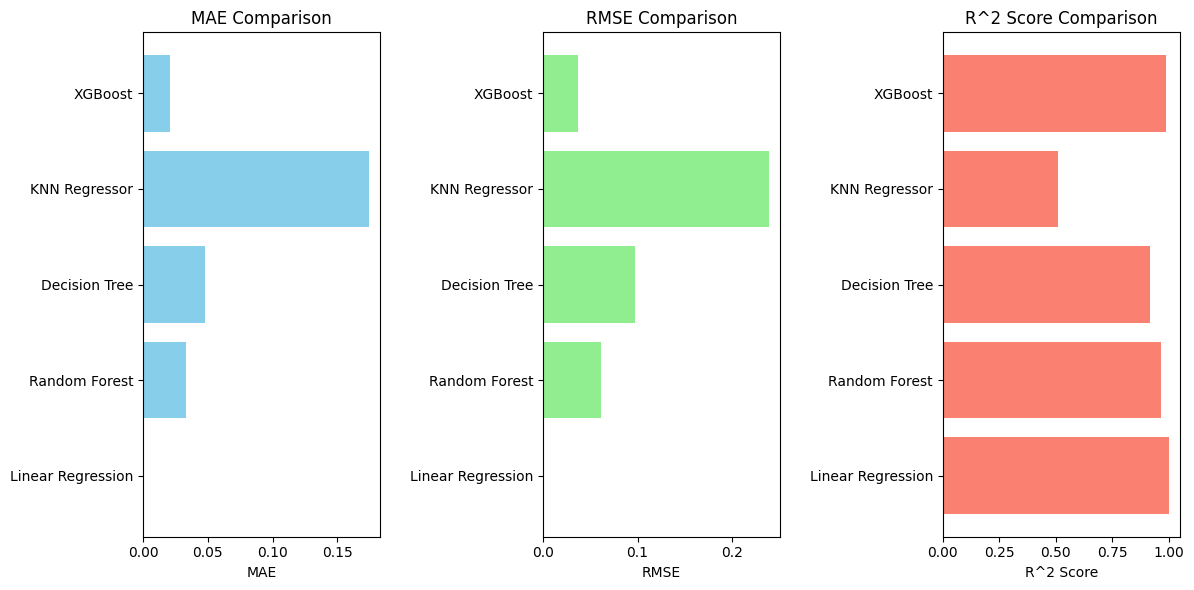

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
}

# Lists to hold metrics
mae_scores = []
rmse_scores = []
r2_scores = []
model_names = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = model.score(X_test, y_test)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    model_names.append(model_name)

    print(f"{model_name} - MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}")

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R^2 Score': r2_scores
})

print("\nModel Comparison:")
print(comparison_df)

# Plot the comparison for a clear visual representation
plt.figure(figsize=(12, 6))

# Subplot for MAE
plt.subplot(1, 3, 1)
plt.barh(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.title('MAE Comparison')
plt.xlabel('MAE')

# Subplot for RMSE
plt.subplot(1, 3, 2)
plt.barh(comparison_df['Model'], comparison_df['RMSE'], color='lightgreen')
plt.title('RMSE Comparison')
plt.xlabel('RMSE')

# Subplot for R^2 Score
plt.subplot(1, 3, 3)
plt.barh(comparison_df['Model'], comparison_df['R^2 Score'], color='salmon')
plt.title('R^2 Score Comparison')
plt.xlabel('R^2 Score')

plt.tight_layout()
plt.show()

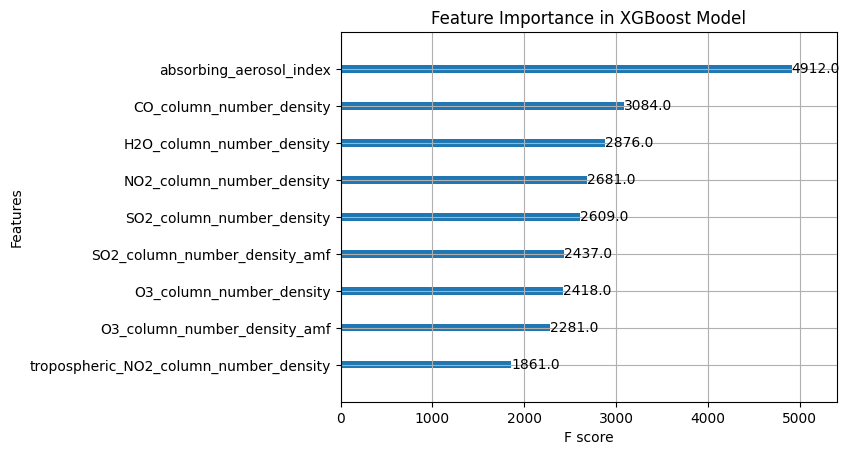

In [ ]:
# Plot feature importance for XGBoost
xgb_model = models["XGBoost"]
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance in XGBoost Model')
plt.show()

In [ ]:
# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for XGBoost:", grid_search.best_params_)
print("Best RMSE Score from GridSearch:", np.sqrt(-grid_search.best_score_))

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best RMSE Score from GridSearch: 0.03743341067741796
